# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [16]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
anio = 2026
name_file = '3_dias' 
nombre_archivo = f'../data/data_forecast_{anio}/data_forecast_{anio}_silver/numero_membresia_{name_file}_limpio.csv'
print(f"Cargando el archivo: {nombre_archivo}")  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Cargando el archivo: ../data/data_forecast_2026/data_forecast_2026_silver/numero_membresia_3_dias_limpio.csv
Rango de fechas: 2022-07-27 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
0,1,234.0,2022-07-27,1.0
1,1,234.0,2022-08-09,1.0
2,1,234.0,2022-08-10,1.0
3,8,1872.0,2022-08-13,8.0
4,16,3744.0,2022-08-14,16.0


In [17]:
df_main.describe()

,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
count,1208.000000,1208.000000,1208,1208.000000
mean,38.485099,9286.897169,2024-04-05 10:59:12.317880832,36.195364
min,1.000000,234.000000,2022-07-27 00:00:00,1.000000
25%,23.000000,5382.000000,2023-06-08 18:00:00,23.000000
50%,34.000000,8123.730000,2024-04-05 12:00:00,34.000000
75%,50.000000,12157.072500,2025-02-01 06:00:00,47.000000
max,160.000000,39053.000000,2025-11-30 00:00:00,90.000000
std,22.661000,5526.215632,NaN,18.657598


Filtro para obtener muestra de datos

In [18]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'cantidad_Vendida_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [19]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """
df['cap'] = 90

# 2. Configurar el modelo con crecimiento logístico
m = Prophet(
            changepoint_prior_scale=0.2,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
            seasonality_prior_scale=20.0,  # Damos más peso a la estacionalidad
            daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
            #########
            growth='logistic', 
            seasonality_mode='multiplicative',
            yearly_seasonality=True)

m.add_country_holidays(country_name='MX')
m.fit(df)


17:04:54 - cmdstanpy - INFO - Chain [1] start processing
17:04:54 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [20]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365)
future['cap'] = 90

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds  cap
1568 2026-11-26   90
1569 2026-11-27   90
1570 2026-11-28   90
1571 2026-11-29   90
1572 2026-11-30   90


Paso 5: Realizar la Predicción (Forecast)

In [21]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds       yhat  yhat_lower  yhat_upper
1568 2026-11-26  38.544662   22.327998   54.630233
1569 2026-11-27  46.280556   31.155667   61.584296
1570 2026-11-28  42.290995   25.797332   59.171698
1571 2026-11-29  40.330465   24.236377   57.082510
1572 2026-11-30  25.481774   10.221400   42.071358


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

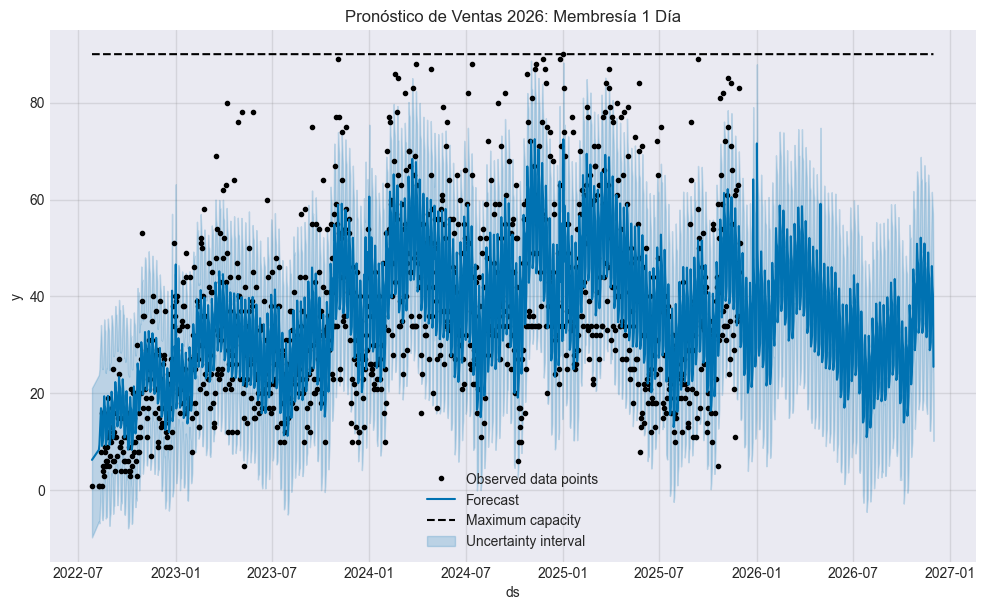

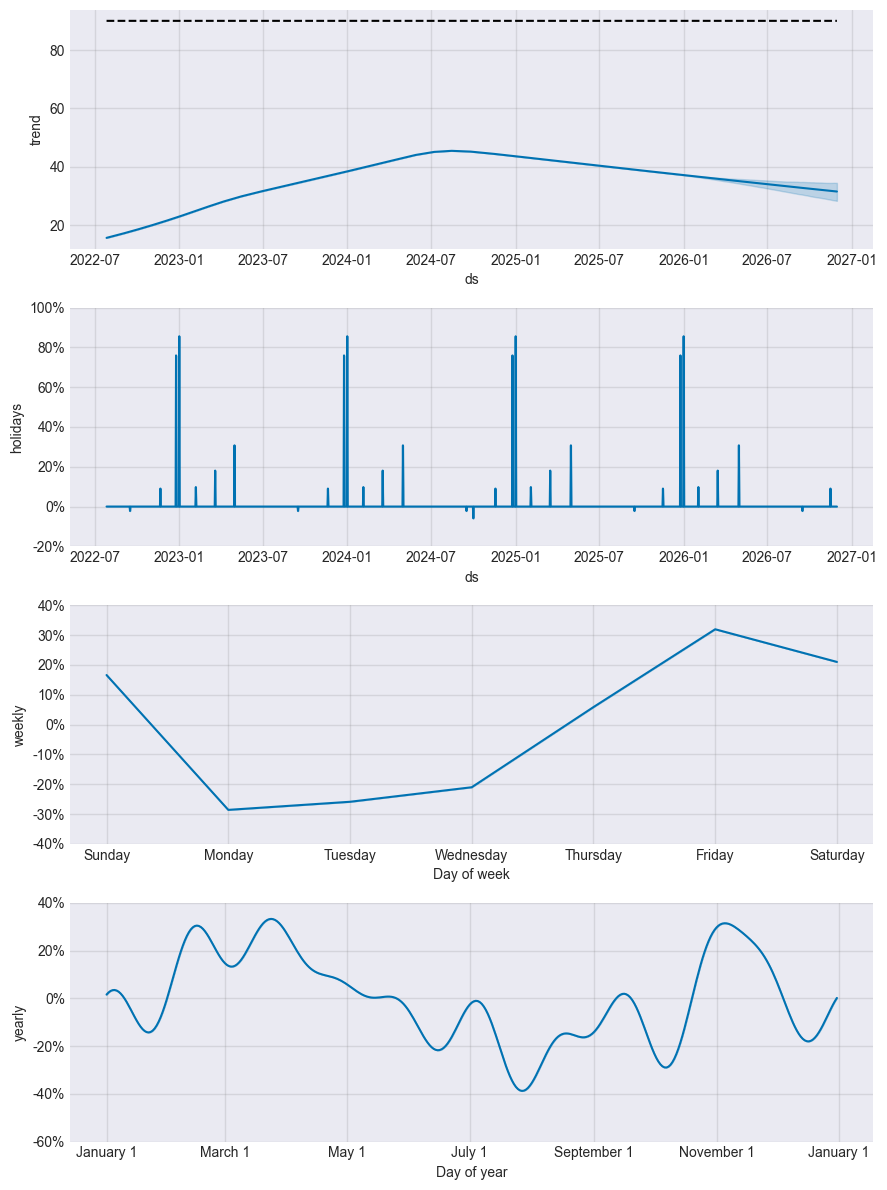

In [22]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas 2026: Membresía 1 Día")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [23]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(0).reset_index()
print(monthly_sales)

      month    yhat  yhat_lower  yhat_upper
0   2022-07     6.0       -10.0        21.0
1   2022-08   279.0       -49.0       609.0
2   2022-09   492.0        35.0       952.0
3   2022-10   555.0        68.0      1032.0
4   2022-11   760.0       292.0      1234.0
5   2022-12   654.0       165.0      1131.0
6   2023-01   707.0       221.0      1194.0
7   2023-02   864.0       424.0      1301.0
8   2023-03  1045.0       563.0      1535.0
9   2023-04   981.0       513.0      1444.0
10  2023-05   921.0       434.0      1405.0
11  2023-06   808.0       336.0      1273.0
12  2023-07   803.0       318.0      1285.0
13  2023-08   812.0       327.0      1294.0
14  2023-09   986.0       517.0      1452.0
15  2023-10  1008.0       524.0      1497.0
16  2023-11  1369.0       901.0      1830.0
17  2023-12  1123.0       644.0      1602.0
18  2024-01  1147.0       656.0      1632.0
19  2024-02  1414.0       964.0      1868.0
20  2024-03  1625.0      1140.0      2114.0
21  2024-04  1416.0       945.0 

In [24]:
monthly_sales.to_csv(f"../data/data_forecast_{anio}/data_forecast_{anio}_gold/forecast_numero_{name_file}_{anio}_monthly.csv")

In [25]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/3 [00:00<?, ?it/s]

17:04:58 - cmdstanpy - INFO - Chain [1] start processing
17:04:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]17:04:59 - cmdstanpy - INFO - Chain [1] start processing
17:04:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]17:05:01 - cmdstanpy - INFO - Chain [1] start processing
17:05:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

  horizon       rmse      mape
0  9 days  12.759094  0.329375
1 10 days  15.106947  0.342081
2 11 days  17.102857  0.357599
3 12 days  17.073967  0.363395
4 13 days  17.391851  0.383457
